# Linea 152

## Motivación

El 21/01/2023 me tomé un colectivo de la línea 152 y me paré cerca de los asientos del fondo. No me quedaba mucha batería en el cel así que me puse a divagar. Arriba de una ventanilla veo pegado el siguiente cartel:

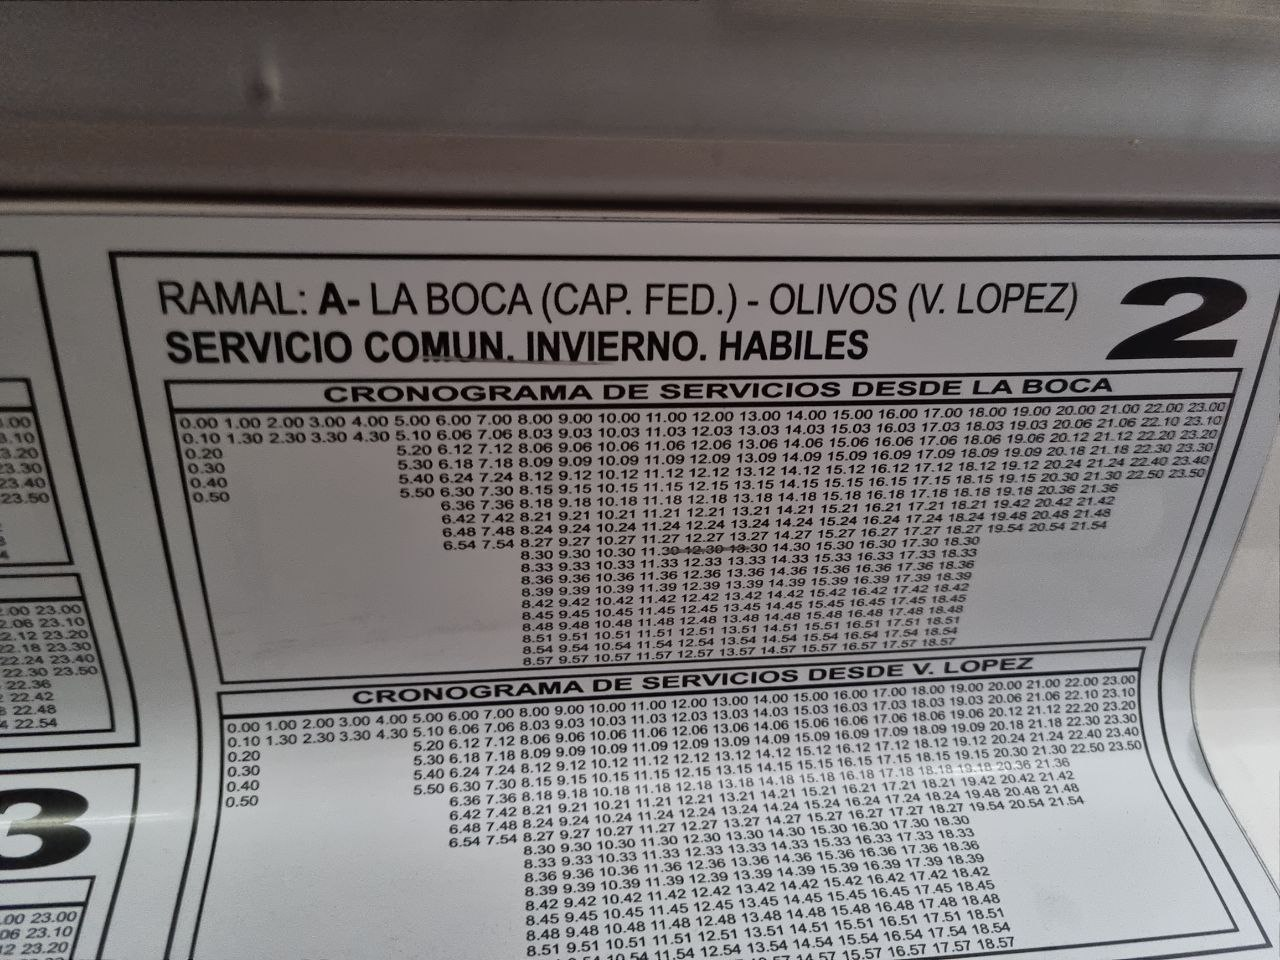

Listado de horarios de salidas de colectivos V.Lopez - La Boca

Me puse a pensar ¿Cuántos colectivos serán necesarios para poder cubrir todos los horarios de la foto?

## Definición del problema

Queremos saber cuántos colectivos son necesarios para cubrir todos los servicios de la foto (ida y vuelta).

Para simplificar el problema, considerando que los horarios de salida de ida y vuelta son iguales, nos vamos a quedar con la parte de arriba de la foto **CRONOGRAMA DE SERVICIOS DESDE LA BOCA** y cualquier resultado que encontremos lo duplicamos.

### Información disponible

Veamos la tabla de horarios. Podemos ver que hay:
- 4 horas con salidas cada 30 minutos o 2 salidas
- 4 horas con salidas cada 10 minutos o 6 salidas
- 5 horas con salidas cada 6 minutos o 10 salidas
- 11 horas con salidas cada 3 minutos o 20 salidas

Que completan las 24 horas del día.

## Soluciones

Vemos algunas posibles soluciones al problema.

### Estrategia naive

La respuesta más fácil y rápida es disponer de un colectivo para cada salida, si llamamos:
- $Q_v = $ Cantidad de viajes
- $F_i = $ Cantidad de salidas en la hora $i, 0 \leq i < 23$

Y queremos un colectivo para cada salida, podemos calcular

$$Q_v = \sum_{i = 0}^{23}F_i$$

Usando los datos de la tabla,

$$Q_v = 6+2+2+2+2+6+10+10+20+20+20+20+20+20+20+20+20+20+20+10+10+10+6+6$$

$$Q_v = 4*2 + 4*6 + 5*10 + 11*20 = 302$$

Así, serán necesarios $302 * 2 = 604$ colectivos

### Reutilizando colectivos

Evidentemente la estrategia naive no parece ser la más eficiente al no considerar que un mismo colectivo puede hacer más de un viaje por día. Sin contar el espacio necesario para estacionar todos estos colectivos, según [ChatGPT](https://chat.openai.com):

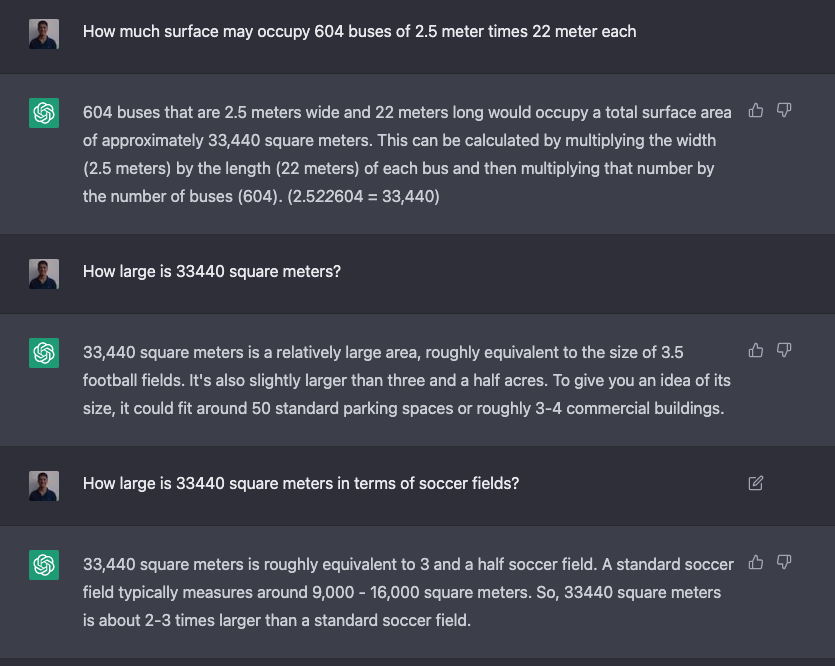

Así que hay que buscar otra solución al problema.

La estrategia es reutilizar colectivos. Vamos a entender que un colectivo se reutiliza cuando realiza un recorrido de punta a punta desde alguna de las cabeceras, al llegar al final espera un tiempo determinado y vuelve a salir en sentido contrario respetando la tabla de horarios.

Algunas de las preguntas que necesitamos responder:
1. ¿Cuánto tarda un colectivo en hacer el recorrido de punta a punta?
2. ¿Qué tiempo de espera hay entre qué llega al final del recorrido y arranca hacia el otro sentido?

### API GCBA

Para calcular cuanto tarda un colectivo en completar la totalidad del recorrido, vamos a usar la API transporte del GCBA. 

- [API docs](https://www.buenosaires.gob.ar/desarrollourbano/transporte/apitransporte)

La api nos permite conocer en tiempo real la posición de los colectivos de una determinada linea, así, podemos calcular el horario de salida de un colectivo y el de llegada al final del recorrido.

In [1]:
import requests
import os
from dotenv import load_dotenv
import pandas as pd
import datetime
import time

In [2]:
load_dotenv()

True

In [3]:
# Configuración de la request
url = "https://apitransporte.buenosaires.gob.ar"
endpoint = "colectivos/vehiclePositions"
params = [
    ("json", 1),
    ("client_id", os.environ["client_id"]),
    ("client_secret", os.environ["client_secret"]),
    ("agency_id", 20) # id de empresa tandilense = linea 152
]

In [4]:
response = requests.get(os.path.join(url, endpoint), params=params)

In [5]:
data = response.json()["_entity"]

In [6]:
df = pd.json_normalize(data)

In [7]:
df.dropna(axis=1, how="all", inplace=True)

In [8]:
# Dropeamos los colectivos en terminal
df.dropna(inplace=True)

In [9]:
# Creamos un timestamp del momento de obtención de los datos
df["timestamp"] = pd.Timestamp.now()

In [10]:
def get_start_datetime(row):
    return datetime.datetime.strptime(row["_vehicle._trip._start_date"]+ " " + row["_vehicle._trip._start_time"], "%Y%m%d %H:%M:%S")

In [11]:
# Creamos un objeto datetime con la fecha-hora de inicio del recorrido
df["start_datetime"] = df.apply(lambda row: get_start_datetime(row), axis = 1)

In [12]:
# Agregamos una columna con la diferencia entre el tiempo de inicio y el actual
df["timedelta"] = df["timestamp"] - df["start_datetime"]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 1 to 87
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype          
---  ------                                 --------------  -----          
 0   _id                                    74 non-null     object         
 1   _is_deleted                            74 non-null     bool           
 2   _vehicle._congestion_level             74 non-null     int64          
 3   _vehicle._current_status               74 non-null     int64          
 4   _vehicle._current_stop_sequence        74 non-null     int64          
 5   _vehicle._occupancy_status             74 non-null     int64          
 6   _vehicle._position._bearing            74 non-null     int64          
 7   _vehicle._position._latitude           74 non-null     float64        
 8   _vehicle._position._longitude          74 non-null     float64        
 9   _vehicle._position._odometer           74 non-null     i

### Mapa de posiciones

Para entender la información que nos devuelve la API vamos a graficar la posición de los colectivos usando

https://mobisoftinfotech.com/tools/plot-multiple-points-on-map/

In [14]:
def print_gps_point(row):
    """
    Dada una row del DataFrame, imprimir en pantalla la información necesaria para graficar
    Colores:
    - Rojo: colectivo hacia Olivos
    - Azul: colectivo hacia La Boca
    - Verde: colectivo en terminal
    """
    color = ("#ff0000", "#0000ff", "#00ff00")[int(row["_vehicle._trip._direction_id"])]
    print(f"{row['_vehicle._position._latitude']},{row['_vehicle._position._longitude']},{color},marker,{row['_id']}")

Posiciones de colectivos 23/01/2023 20:15hs

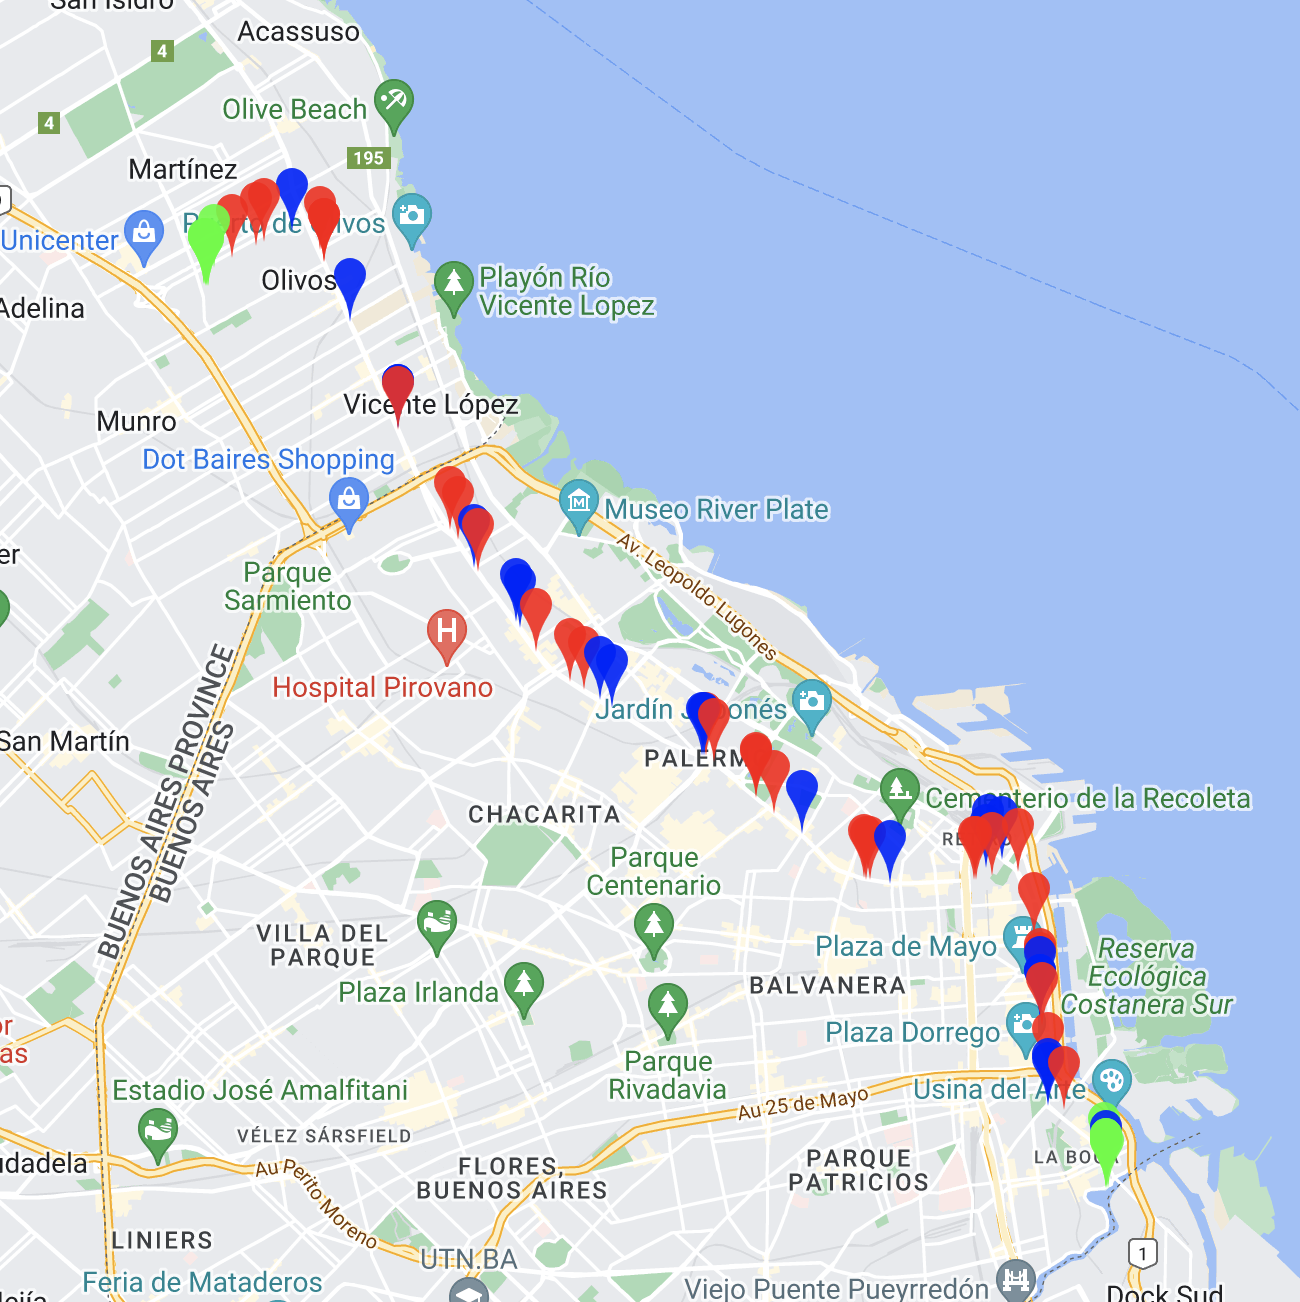

### Duración del recorrido

Necesitamos obtener la duración de punta a punta del recorrido. Para ello podemos usar el dato de start_time que provee la api y calcular el timestamp de llegada al final del recorrido

In [15]:
def get_euclidean_distance(p, q):
    return (((p[0] - q[0])**2) + ((p[1] - q[1])**2))**(1/2)

In [16]:
def get_dist_to_final(row):
    direccion = int(row["_vehicle._trip._direction_id"])
    terminales = [(-34.5151757,-58.5124359), (-34.6390704,-58.359032)] # [(olivos), (la boca)]
    coords = (row['_vehicle._position._latitude'], row['_vehicle._position._longitude'])
    dist = get_euclidean_distance(coords, terminales[direccion])
    return dist

In [17]:
df["distancia_al_final"] = df.apply(lambda row: get_dist_to_final(row), axis=1)

In [18]:
# Definición del target distancia a la terminal
dist_target = 0.005

In [19]:
df.columns

Index(['_id', '_is_deleted', '_vehicle._congestion_level',
       '_vehicle._current_status', '_vehicle._current_stop_sequence',
       '_vehicle._occupancy_status', '_vehicle._position._bearing',
       '_vehicle._position._latitude', '_vehicle._position._longitude',
       '_vehicle._position._odometer', '_vehicle._position._speed',
       '_vehicle._stop_id', '_vehicle._timestamp', '_vehicle._vehicle._id',
       '_vehicle._vehicle._label', '_vehicle._trip._direction_id',
       '_vehicle._trip._route_id', '_vehicle._trip._schedule_relationship',
       '_vehicle._trip._start_date', '_vehicle._trip._start_time',
       '_vehicle._trip._trip_id', 'timestamp', 'start_datetime', 'timedelta',
       'distancia_al_final'],
      dtype='object')

Vamos a considerar que un colectivo finaliza su recorrido cuando **distancia_al_final** sea menor igual a **dist_target**

In [20]:
# Obtenemos los colectivos que llegaron a destino
finalizados = df[df["distancia_al_final"] <= dist_target]

In [21]:
# Guardamos en csv
finalizados.to_csv('finalizados.csv', mode='a', index=False, header=False)

### Obtención de datos

Con todo lo armado, vamos a armar un script que corra cada 60 segundos, durante al menos 4 horas y nos guarde la información de los recorridos finalizados en el archivo **finalizados.csv**

In [22]:
def get_data_from_api():
    url = "https://apitransporte.buenosaires.gob.ar"
    endpoint = "colectivos/vehiclePositions"
    params = [
        ("json", 1),
        ("client_id", os.environ["client_id"]),
        ("client_secret", os.environ["client_secret"]),
        ("agency_id", 20) # id de empresa tandilense = linea 152
    ]
    response = requests.get(os.path.join(url, endpoint), params=params)
    data = response.json()["_entity"]
    return data

In [23]:
def get_df(data):
    df = pd.json_normalize(data)
    df.dropna(axis=1, how="all", inplace=True)
    df.dropna(inplace=True)
    df["timestamp"] = pd.to_datetime(df["_vehicle._timestamp"], unit="s")
    df["start_datetime"] = df.apply(lambda row: get_start_datetime(row), axis = 1)
    df["timedelta"] = df["timestamp"] - df["start_datetime"]
    return df

In [24]:
def get_distancias(df):
    df["distancia_al_final"] = df.apply(lambda row: get_dist_to_final(row), axis=1)

In [25]:
def get_df_finalizados(df, dist_target):
    finalizados = df[df["distancia_al_final"] <= dist_target]
    return finalizados

In [26]:
def save_to_csv(df):
    df.to_csv('finalizados.csv', mode='a', index=False, header=False)

In [34]:
def get_colectivos_finalizados():
    t0 = time.time()
    t1 = time.time()
    while t1 - t0 < 14400:
        data = get_data_from_api()
        df = get_df(data)
        get_distancias(df)
        finalizados = get_df_finalizados(df, 0.005)
        save_to_csv(finalizados)
        t1 = time.time()
        print(14400 - (t1 - t0))
        time.sleep(60)

### Calculo del tiempo de recorrido

In [49]:
finalizados = pd.read_csv("finalizados.csv", names=list(df.columns))

In [50]:
finalizados = finalizados[["_vehicle._trip._direction_id", "start_datetime", "timestamp", "timedelta"]]

In [51]:
finalizados.head()

,_vehicle._trip._direction_id,start_datetime,timestamp,timedelta
0,0.0,2023-01-24 08:15:00.000000,2023-01-24 10:15:54.090717,0 days 02:00:54.090717
1,0.0,2023-01-24 08:33:00.000000,2023-01-24 10:15:54.090717,0 days 01:42:54.090717
2,0.0,2023-01-24 08:36:00.000000,2023-01-24 10:15:54.090717,0 days 01:39:54.090717
3,0.0,2023-01-24 08:15:00.000000,2023-01-24 10:16:25.726502,0 days 02:01:25.726502
4,0.0,2023-01-24 08:33:00.000000,2023-01-24 10:16:25.726502,0 days 01:43:25.726502


In [54]:
finalizados.shape

(562, 4)

In [55]:
# Elimino los duplicados <-> direction_id & start_datetime son iguales
finalizados.drop_duplicates(subset=["_vehicle._trip._direction_id", "start_datetime"],
                           inplace=True)

In [57]:
finalizados.shape

(134, 4)

In [70]:
finalizados.reset_index(drop=True, inplace=True)

In [71]:
finalizados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   _vehicle._trip._direction_id  134 non-null    float64
 1   start_datetime                134 non-null    object 
 2   timestamp                     134 non-null    object 
 3   timedelta                     134 non-null    object 
dtypes: float64(1), object(3)
memory usage: 4.3+ KB


In [81]:
finalizados["start_datetime"] = finalizados["start_datetime"].str.replace('\.\d*','', regex=True)
finalizados["timestamp"] = finalizados["timestamp"].str.replace('\.\d*','', regex=True)
finalizados["timedelta"] = finalizados["timedelta"].str.replace('\.\d*','', regex=True)

In [82]:
finalizados.sample(5)

,_vehicle._trip._direction_id,start_datetime,timestamp,timedelta
58,0.0,2023-01-24 16:42:00,2023-01-24 21:22:20,0 days 04:40:20
41,0.0,2023-01-24 16:15:30,2023-01-24 20:48:48,0 days 04:33:18
1,0.0,2023-01-24 08:33:00,2023-01-24 10:15:54,0 days 01:42:54
77,1.0,2023-01-24 17:46:30,2023-01-24 22:09:46,0 days 04:23:16
17,0.0,2023-01-24 09:18:00,2023-01-24 11:00:43,0 days 01:42:43


In [ ]:
# Convertir las str en objetos datetime
# finalizados["start_datetime"] = finalizados["start_datetime"].apply(lambda row: )